<a href="https://colab.research.google.com/github/tengkukevin/bert-cnn/blob/main/roberta_cnn_suicide-50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisialisasi

In [ ]:
from transformers import RobertaTokenizer
import tensorflow as tf
from transformers import TFRobertaModel
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import gdown
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [ ]:
# Baca dataset CSV
# Dataset menggunakan ISEAR
# Download dari https://www.kaggle.com/datasets/juanchristopheryoung/isear-dataset
# df = pd.read_csv('https://raw.githubusercontent.com/tengkukevin/bert-cnn/refs/heads/main/isear.csv')
# df = pd.read_csv('https://drive.google.com/file/d/1OnaKteatcNjgDyNAob2w3cGb82ktEHfR/view?usp=sharing')
# df = pd.read_csv('https://drive.google.com/uc?id=1OnaKteatcNjgDyNAob2w3cGb82ktEHfR')
nltk.download('stopwords')

def clean_text(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()

    # Menghapus karakter non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Menghapus angka
    text = re.sub(r'\d+', '', text)

    # Menghapus tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus stopwords (jika perlu)
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

file_url = 'https://drive.google.com/uc?id=1OnaKteatcNjgDyNAob2w3cGb82ktEHfR'
output = 'dataset.csv'

# Download file
gdown.download(file_url, output, quiet=False)

# Load dataset
df = pd.read_csv(output)
sample_df = df.sample(frac=0.5, random_state=42)

# Kolom pertama adalah teks, kolom kedua adalah label
texts = sample_df.iloc[:, 1].astype(str).apply(clean_text)
labels = sample_df.iloc[:, 2].astype(str)

print(texts.head())
print(labels.head())

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize teks menggunakan tokenizer ROBERTA
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
inputs = tokenizer(
    texts.tolist(),          # Konversi teks menjadi daftar string
    return_tensors="tf",     # Format TensorFlow
    padding=True,            # Tambahkan padding agar panjangnya sama
    truncation=True,         # Potong teks yang terlalu panjang
    max_length=128           # Panjang maksimum token
)

# Setting parameter
learning_rate = 4e-5
epoch = 25
batch_size = 16
dropout_rate = 0.5

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Downloading...
From (original): https://drive.google.com/uc?id=1OnaKteatcNjgDyNAob2w3cGb82ktEHfR
From (redirected): https://drive.google.com/uc?id=1OnaKteatcNjgDyNAob2w3cGb82ktEHfR&confirm=t&uuid=88c08ebf-0b2e-431c-a6d9-bfe0b8015cca
To: /content/dataset.csv
100%|██████████| 167M/167M [00:04<00:00, 40.4MB/s]


74414     dont know months self harm free urge gets stro...
149516    start becoming rich start company become affor...
12484     poem haiku umegamedev hi hello hello stop fuck...
14043     ive honestly got idea anymoreit feels everyone...
30673     ever cry like think unfair life cry cant cry e...
Name: text, dtype: object
74414         suicide
149516    non-suicide
12484     non-suicide
14043         suicide
30673     non-suicide
Name: class, dtype: object


In [ ]:
# Ubah label ke bentuk one-hot encoding
encoded_labels = to_categorical(encoded_labels)

# Convert Tensor ke Numpy array
input_ids = np.array(inputs['input_ids'])
attention_mask = np.array(inputs['attention_mask'])

# Bagi dataset menjadi data train dan validation
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, encoded_labels, test_size=0.2, random_state=42
)

# Proses Training

In [ ]:
class RobertaCNNEmotionModel(tf.keras.Model):
    def __init__(self, roberta_model_name='roberta-base', num_classes=3, dropout_rate=0.3):
        super(RobertaCNNEmotionModel, self).__init__()
        self.roberta = TFRobertaModel.from_pretrained(roberta_model_name)
        self.conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')
        self.pool1 = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training = False):
        roberta_output = self.roberta(inputs)[0]  # Take the last hidden state (sequence output)
        conv_output = self.conv1(roberta_output)
        pooled_output = self.pool1(conv_output)
        dropout_output = self.dropout(pooled_output, training=training)
        return self.dense(dropout_output)

In [ ]:
# Inisialisasi model RoBERTa-CNN
model = RobertaCNNEmotionModel(num_classes=len(label_encoder.classes_), dropout_rate=dropout_rate)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Latih model
history = model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epoch, batch_size=batch_size)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/25
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - accuracy: 0.7923 - loss: 0.4655 - precision_1: 0.7923 - recall_1: 0.7923 - val_accuracy: 0.9225 - val_loss: 0.2066 - val_precision_1: 0.9225 - val_recall_1: 0.9225
Epoch 2/25
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - accuracy: 0.9254 - loss: 0.2013 - precision_1: 0.9254 - recall_1: 0.9254 - val_accuracy: 0.9438 - val_loss: 0.1556 - val_precision_1: 0.9438 - val_recall_1: 0.9438
Epoch 3/25
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.9414 - loss: 0.1591 - precision_1: 0.9414 - recall_1: 0.9414 - val_accuracy: 0.9480 - val_loss: 0.1383 - val_precision_1: 0.9480 - val_recall_1: 0.9480
Epoch 4/25
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.9496 - loss: 0.1387 - precision_1: 0.9496 - recall_1: 0.9496 - val_accuracy: 0.9526 - val_loss: 0.1282 - val_precision_1: 0.9526 - val_recall_1: 0.9526
Epoch 5/25
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.9533 - loss: 0.1269 - precision_1: 0.9533

# Evaluasi

In [ ]:
# Evaluasi pada data validasi
model.evaluate(val_inputs, val_labels)

# Prediksi label
y_pred = model.predict(val_inputs)

# Ambil label dengan probabilitas tertinggi (argmax)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(val_labels, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

726/726 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9623 - loss: 0.1103 - precision_1: 0.9623 - recall_1: 0.9623
726/726 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step
Precision: 0.9629626694917053
Recall: 0.962599103757325
F1-Score: 0.9625883945720382


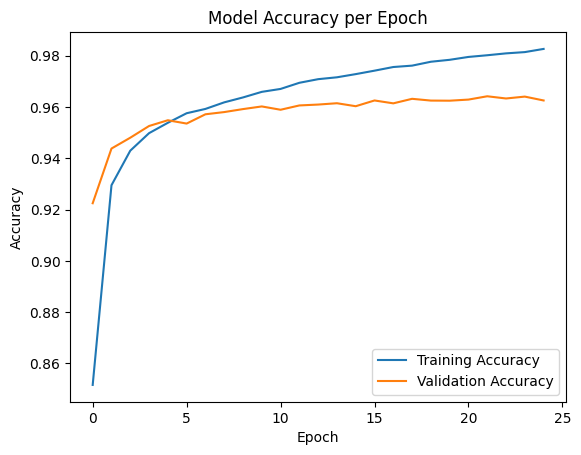

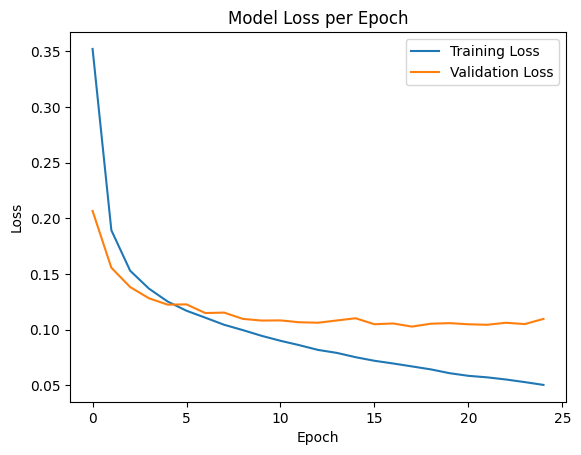

In [ ]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Testing

In [ ]:
# Prediksi emosi pada teks baru
new_texts = ["why this is happening to me", "I deserve to be treated with respect, but you constantly belittle and demean me.", "I'm tired of feeling invisible in our relationship. It's time to have a conversation about the neglect I've been experiencing."]
new_inputs = tokenizer(new_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)

predictions = model.predict(new_inputs['input_ids'])
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
['non-suicide' 'non-suicide' 'non-suicide']
